In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from datetime import datetime

import pysal as ps
import matplotlib.pyplot as plt
import matplotlib.collections as mplc
%matplotlib inline
import seaborn as sns
import shapely

from shapely import geometry as sgeom
from shapely.geometry import Point
import descartes as des
from shapely import ops

import warnings
warnings.simplefilter('ignore') 

# 0 Data processing

In [187]:
# main document path
DATA_PATH = "./data/raw_data/Accident data/"
MAP_PATH = "./data/Map/LSOA/"
FILE_NAME = "Accidents_2019.csv"

# obtain accidents data in 2019
raw_data = pd.read_csv(DATA_PATH+FILE_NAME)
raw_data = raw_data.reset_index(drop=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int64  
 6   Accident_Severity                            117536 non-null  int64  
 7   Number_of_Vehicles                           117536 non-null  int64  
 8   Number_of_Casualties                         117536 non-null  int64  
 9   Date                                         117536 non-nul

In [188]:
# input accidents data in 2019 into a GeoDataFrame
accidents_19 = gpd.GeoDataFrame(raw_data, geometry = [Point(xy) for xy in zip (raw_data['Location_Easting_OSGR'], raw_data['Location_Northing_OSGR'])])

In [189]:
len(accidents_19.Accident_Index.unique())

117536

In [190]:
# input LSOA map
lsoa_gdf = gpd.read_file('./data/map/LSOA_accident.shp')

In [191]:
# merge all road traffic accidents into LSOA map in London in 2019
PointInPolys = gpd.sjoin(lsoa_gdf, accidents_19, op = 'intersects', how='right')
accidents_gdf = gpd.GeoDataFrame(PointInPolys, geometry = [Point(xy) for xy in zip (PointInPolys['Location_Easting_OSGR'], PointInPolys['Location_Northing_OSGR'])])
accidents_gdf.dropna(axis = 0, inplace = True)
accidents_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25252 entries, 0 to 97741
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   index_left                                   25252 non-null  float64 
 1   code                                         25252 non-null  object  
 2   lsoa                                         25252 non-null  object  
 3   borough                                      25252 non-null  object  
 4   Accident_Index                               25252 non-null  object  
 5   Location_Easting_OSGR                        25252 non-null  float64 
 6   Location_Northing_OSGR                       25252 non-null  float64 
 7   Longitude                                    25252 non-null  float64 
 8   Latitude                                     25252 non-null  float64 
 9   Police_Force                                 25252 no

In [7]:
# convert its type into a dataframe
accidents_pd = pd.DataFrame(accidents_gdf)
accidents_pd.drop('geometry', axis = 1, inplace = True)
# change the type of Accident_Index into string
accidents_pd['Accident_Index'] = accidents_pd['Accident_Index'].astype(str)

In [192]:
# input casualty data
casualty_pd = pd.read_csv(DATA_PATH+'Casualties_2019.csv')
casualty_pd.info()
# change the type of Accident_Index into string
casualty_pd['Accident_Index'] = casualty_pd['Accident_Index'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153158 entries, 0 to 153157
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Accident_Index                      153158 non-null  object
 1   Vehicle_Reference                   153158 non-null  int64 
 2   Casualty_Reference                  153158 non-null  int64 
 3   Casualty_Class                      153158 non-null  int64 
 4   Sex_of_Casualty                     153158 non-null  int64 
 5   Age_of_Casualty                     153158 non-null  int64 
 6   Age_Band_of_Casualty                153158 non-null  int64 
 7   Casualty_Severity                   153158 non-null  int64 
 8   Pedestrian_Location                 153158 non-null  int64 
 9   Pedestrian_Movement                 153158 non-null  int64 
 10  Car_Passenger                       153158 non-null  int64 
 11  Bus_or_Coach_Passenger              153

In [158]:
## delete the unknown value
casualty_pd.drop(index=casualty_pd[casualty_pd['Age_Band_of_Casualty'] == -1].index, inplace = True)
# merge casualty data into road traffic accidents
accidents_casualty_pd = accidents_pd.merge(casualty_pd, on = 'Accident_Index', how = 'left')

In [13]:
# obtain weighting severity index for each accident
def GetSWI(fatal_weight, serious_weight, slight_weight, accidents):
    # Set weight of 5 for fatal accidents
    fatal_acc = accidents[accidents['Accident_Severity'] == 1]
    fatal_acc['SWI'] = fatal_weight
    # Set weight of 3 for serious accidents
    serious_acc = accidents[accidents['Accident_Severity'] == 2]
    serious_acc['SWI'] = serious_weight
    # Set weight of 1 for slight accidents
    slight_acc = accidents[accidents['Accident_Severity'] == 3]
    slight_acc['SWI'] = slight_weight
    # combine all accidents
    w_accidents = pd.concat([fatal_acc,serious_acc,slight_acc],axis=0)
    # obtain weighting severity index and for each accident
    w_accidents['SWI'] = pd.to_numeric(w_accidents['SWI'], errors='coerce').fillna(0)

    return w_accidents

accidents_swi = GetSWI(5, 3, 1, accidents_casualty_pd)
raw_accidents_swi = pd.DataFrame(accidents_swi[['code','lsoa','borough','SWI', 'Accident_Severity', 'Date','Time', 'Day_of_Week', 'Age_of_Casualty', 'Latitude','Longitude','Location_Easting_OSGR','Location_Northing_OSGR']])
# change attribute name
raw_accidents_swi.rename(columns={'Day_of_Week':'Day'}, inplace = True)
raw_accidents_swi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29085 entries, 18 to 29082
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code                    29085 non-null  object 
 1   lsoa                    29085 non-null  object 
 2   borough                 29085 non-null  object 
 3   SWI                     29085 non-null  int64  
 4   Accident_Severity       29085 non-null  int64  
 5   Date                    29085 non-null  object 
 6   Time                    29085 non-null  object 
 7   Day                     29085 non-null  int64  
 8   Age_of_Casualty         28503 non-null  float64
 9   Latitude                29085 non-null  float64
 10  Longitude               29085 non-null  float64
 11  Location_Easting_OSGR   29085 non-null  float64
 12  Location_Northing_OSGR  29085 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 3.1+ MB


In [14]:
# output accidents with severity-weighted index as shapefile
accidents_swi_19 = gpd.GeoDataFrame(raw_accidents_swi, geometry = [Point(xy) for xy in zip (raw_accidents_swi['Location_Easting_OSGR'], raw_accidents_swi['Location_Northing_OSGR'])])
# accidents_wsi_19.to_file(driver='ESRI Shapefile', filename='./data/London/accidents/lsoa_wsi_accidents.shp')

In [15]:
# calculate count of accidents by lsoa
accidents_swi_19['count'] = 1
accidents_swi_pd = accidents_swi_19.groupby('code')['SWI','count'].sum()
accidents_swi_pd.reset_index(inplace=True)
# merge two datasets
accidents_swi_lsoa = accidents_swi_pd.merge(lsoa_gdf, on = 'code', how='outer').fillna(0)
# output accident data for regression analysis
# accidents_swi_lsoa.to_file(driver='ESRI Shapefile', filename='./data/London/regression/All/regression_lsoa.shp')

In [16]:
# set data index as datetime
def TimeOfAccident(accidents):
    accidents['YMDHM'] = accidents.Date+ accidents.Time
    accidents['YMDHM'] = pd.to_datetime(accidents['YMDHM'], format='%d/%m/%Y%H:%M')
    accidents.index = accidents.YMDHM
    accidents['Hour'] = accidents.YMDHM.dt.hour
    accidents = accidents.sort_index()
    return accidents

raw_accidents_swi = TimeOfAccident(raw_accidents_swi)
# obtain 52-weeks data
raw_accidents_swi = raw_accidents_swi['2019-01-01':'2019-12-30']

In [17]:
# set time slot within k hour(s)
def HourWeekIndex(dataframe, k = 0):
    ls = []
    n = 24 / k
    for i in range(k):
        ls.append([m for m in range((i+1) * int(n))])
    hour_list = [ls[0]]
    for i in range(len(ls)-1):
        hour_list.append(list(set(ls[i + 1]).difference(set(ls[i]))))
    
    # creat a new column called Hour_ID
    dataframe['Hour_ID'] = pd.Series(np.array(len(dataframe['code'])))
    dataframe['Hour_ID'].fillna(0, inplace = True)
    
    for i in range(len(ls)):
        y = dataframe.apply(lambda x: int(x['Hour'] in hour_list[i]) * i , axis = 1)
        dataframe['Hour_ID'] += y
    
    # Select data on weekdays and weekend
    dataframe['Day_ID'] = pd.Series(np.array(len(dataframe['code'])))
    dataframe['Day_ID'].fillna(0, inplace = True)
    dataframe['Day_ID'][dataframe['Day'].isin([2,3,4,5,6])]=0
    dataframe['Day_ID'][dataframe['Day'].isin([1,7])]=1
    
    return dataframe

# add hourly index with k of 12
raw_accidents_swi = HourWeekIndex(raw_accidents_swi, k = 12)
# add columns of the count of accidents
raw_accidents_swi['count']=1

In [18]:
raw_accidents_swi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29023 entries, 2019-01-01 00:20:00 to 2019-12-30 22:54:00
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   code                    29023 non-null  object        
 1   lsoa                    29023 non-null  object        
 2   borough                 29023 non-null  object        
 3   SWI                     29023 non-null  int64         
 4   Accident_Severity       29023 non-null  int64         
 5   Date                    29023 non-null  object        
 6   Time                    29023 non-null  object        
 7   Day                     29023 non-null  int64         
 8   Age_of_Casualty         28442 non-null  float64       
 9   Latitude                29023 non-null  float64       
 10  Longitude               29023 non-null  float64       
 11  Location_Easting_OSGR   29023 non-null  float64       
 12  Location_No

In [19]:
# define the age bands with age_ls
def AgeGroup(dataframe, age_ls = []):
    dataframe['Age_Band'] = pd.Series(np.array(len(dataframe['code'])))
    dataframe['Age_Band'].fillna(0, inplace = True)

    age_group = []
    age_group.append(age_ls[0])
    for i in range(len(age_ls)-1):
        age = [age_ls[i]+1,age_ls[i+1]]
        age_group.append(age)
    age_group.append(age_ls[-1])

    # set a numeric code for each age band
    dataframe['Age_Band'][dataframe['Age_of_Casualty']<=age_group[0]]=0
    dataframe['Age_Band'][dataframe['Age_of_Casualty']>=age_group[-1]]=len(age_group)-1

    n=0
    for i in age_group[1:-1]:
        n += 1
        dataframe['Age_Band'][(dataframe['Age_of_Casualty'] >= i[0]) & (dataframe['Age_of_Casualty'] <= i[1])]=n    
    
    return dataframe

# grouped by age bands of 0-18, 19-25, 26-35, 36-45, 46-55, 56-65 and over 65
age_ls = [18,25,35,45,55,65]
raw_accidents_swi = AgeGroup(raw_accidents_swi, age_ls=age_ls)

# plot a histgram for these age bands
print('Porportion of each age groups amoung all casualties:\n',raw_accidents_swi.Age_Band.value_counts()/raw_accidents_swi.Age_Band.count())

Porportion of each age groups amoung all casualties:
 2    0.273163
3    0.192158
1    0.160045
4    0.135582
0    0.116115
5    0.069738
6    0.053199
Name: Age_Band, dtype: float64


In [139]:
# accidents by age groups
raw_accidents_age = raw_accidents_swi.dropna(inplace = False)
# raw_accidents_age.info

# 1 Overview of road traffic accidents in London in 2019

## 1.1 Spatiotemporal characteristics exploration

### 1.1.1 Temporal Analysis of Road Traffic Accidents

#### (1) Count of road traffic accidents in each time of a week

In [42]:
# calculate count of road traffic accidents in each time of a week
day_hour_data = raw_accidents_swi.copy()
# reorder the day of accidents
day_hour_data['Day'][day_hour_data.Day==1]=8

day_hour_accidents = day_hour_data.groupby(['Day', 'Hour']).SWI.sum().unstack()
day_hour_accidents

Hour   0    1    2    3    4   5    6    7    8    9   ...   14   15   16  \
Day                                                    ...                  
2     104   42   31   57   27  52  152  294  462  304  ...  254  292  406   
3      49   52   60   31   26  44  106  327  454  292  ...  278  349  383   
4      61   56   42   43   40  30  113  305  473  302  ...  291  441  347   
5      74   64   47   54   39  64  129  310  439  281  ...  245  393  427   
6     108  132   32   46   44  67   86  210  409  271  ...  359  395  439   
7     269  131  125   78  128  80   86  153  133  157  ...  332  325  257   
8     184  181  163  105  104  73   93   86   97  161  ...  287  314  226   

Hour   17   18   19   20   21   22   23  
Day                                      
2     455  458  327  203  191  145  110  
3     453  487  310  278  185  178  130  
4     452  459  385  250  184  271  138  
5     466  506  343  227  206  191  170  
6     486  498  390  335  285  221  234  
7     339  363  340  277  320  258  278  
8     252  300  249  292  246  206  117  

[7 rows x 24 columns]

Text(0.5, 1.0, 'Count of road traffic accidents in each time of a week')

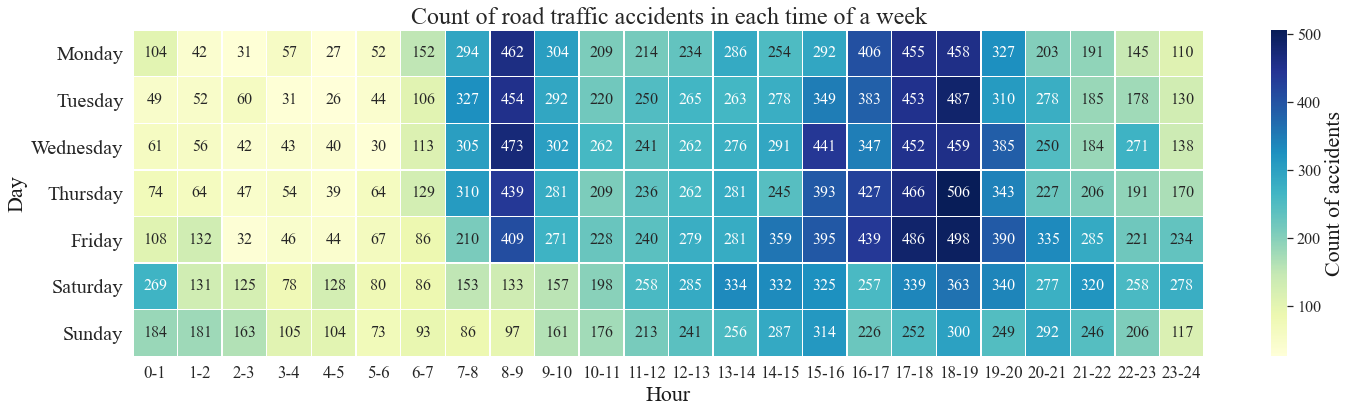

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
sns.set_theme()

label_font = 20
title_font = 24
figure_font = 16

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'
font = {'family': 'sans-serif',
            'color': 'k',
            'weight': 'normal',
            'size': label_font+2,}

hour = [i for i in range(25)]
hours = ['{}-{}'.format(hour[i],hour[i+1]) for i in range(24)]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# draw a heatmap with the count of accidents data
f, ax = plt.subplots(figsize=(24, 6))
sns.heatmap(day_hour_accidents, annot=True, fmt='d', linewidths=.5, cmap='YlGnBu',annot_kws={'size':figure_font}, ax=ax, xticklabels=hours, yticklabels=days)
plt.xlabel('Hour',fontsize=label_font+2, color='k')
plt.ylabel('Day',fontsize=label_font+2, color='k')
# change the font size of x & y axis
plt.xticks(fontsize=label_font-3)
plt.yticks(fontsize=label_font)
cbar = ax.collections[0].colorbar
cbar.set_label(r'Count of accidents',fontdict=font)
#change the figure font of colour bar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=figure_font)

plt.title('Count of road traffic accidents in each time of a week',fontsize=title_font)

#### (2)Severity-weighted index of road traffic accidents in each time of a week

In [69]:
# calculate SWI of road traffic accidents in each time of a week
day_hour_swi = day_hour_data.groupby(['Day', 'Hour']).SWI.sum().unstack().astype(int)

Text(0.5, 1.0, 'Severity-weighted index of road traffic accidents in each time of a week')

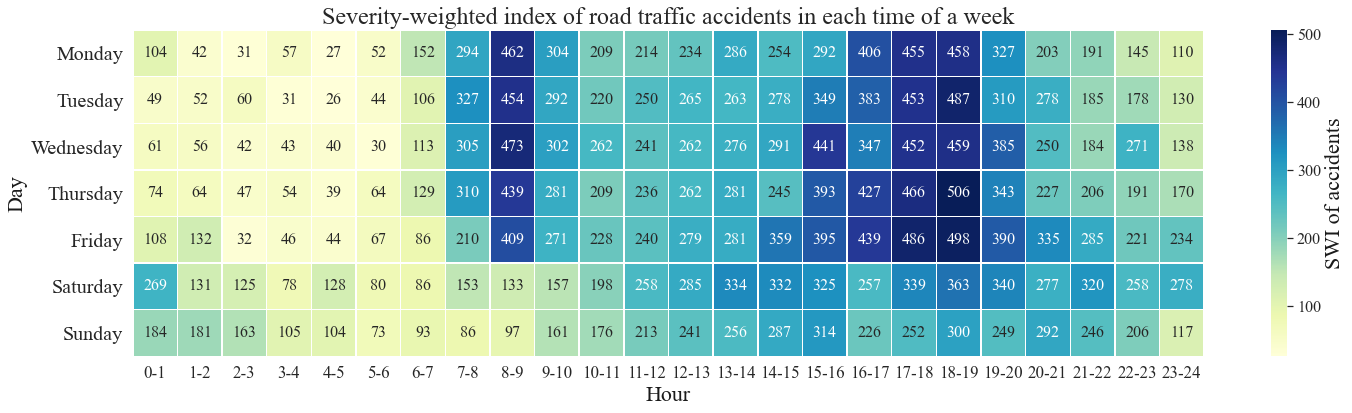

In [105]:
# draw a heatmap with the WSI index of accidents
f, ax = plt.subplots(figsize=(24, 6))
sns.heatmap(day_hour_swi, annot=True, fmt='d', linewidths=.5, cmap='YlGnBu', annot_kws={'size':figure_font}, ax=ax, xticklabels=hours, yticklabels=days)
plt.xlabel('Hour',fontsize=label_font+2, color='k')
plt.ylabel('Day',fontsize=label_font+2, color='k')
# change the font size of x & y axis
plt.xticks(fontsize=label_font-3)
plt.yticks(fontsize=label_font)
cbar = ax.collections[0].colorbar
cbar.set_label(r'SWI of accidents',fontdict=font)
#change the figure font of colour bar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=figure_font)

plt.title('Severity-weighted index of road traffic accidents in each time of a week',fontsize=title_font)

#### (3) Daily pattern

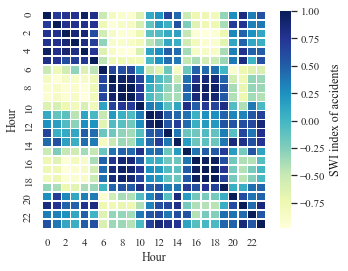

In [35]:
# similarity of swi chaging by time of a day
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
sns.set_theme()

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'
font = {'family': 'sans-serif',
            'color': 'k',
            'weight': 'normal',
            'size': 12,}

f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(day_hour_accidents.corr(), annot=False, linewidths=.5, cmap='YlGnBu')
cbar = ax.collections[0].colorbar
cbar.set_label(r'SWI index of accidents',fontdict=font)

#### (4) Weekly pattern

<AxesSubplot:xlabel='Day', ylabel='Day'>

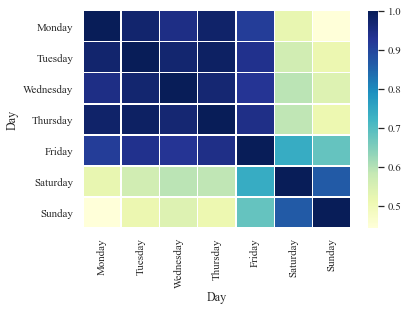

In [36]:
# similarity of swi chaging by time of a week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

p = pd.DataFrame(day_hour_accidents).T.astype(float)
sns.heatmap(p.corr(), annot=False, linewidths=.5,xticklabels=days, yticklabels=days, cmap='YlGnBu')

#### (3) The relationship between severity and casualty age

In [28]:
!pip install pyecharts
from pyecharts.charts import Sankey
from pyecharts import options as opts

Looking in indexes: http://pypi.douban.com/simple


In [29]:
# modify the numeric value of each columns into categorical value
# classify age groups by days of a week
accidents_swi_age = raw_accidents_age.copy()
day_ls = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for i in range(len(day_ls)):
    accidents_swi_age['Day'][accidents_swi_age['Day'] == i+1] = day_ls[i]
# classify age groups by accident severity
severity_ls = ['Fatal','Serious','Slight']
for i in range(len(severity_ls)):
    accidents_swi_age['Accident_Severity'][accidents_swi_age['Accident_Severity'] == i+1] = severity_ls[i]
# define a name for each age group
age_names = []
name = '0 - {}'.format(age_ls[0])
age_names.append(name)
for i in range(len(age_ls)-1):
    name = '{} - {}'.format(age_ls[i]+1,age_ls[i+1])
    age_names.append(name)
name = '{}+'.format(age_ls[-1])
age_names.append(name)

for i in range(len(age_names)):
    accidents_swi_age['Age_Band'][accidents_swi_age['Age_Band'] == i] = age_names[i]

In [30]:
# creat sankey chart for age groups
# define each nodes of sankey chart
nodes = []
values = day_ls + severity_ls + age_names
for i in values:
    dicts = {}
    dicts['name'] = i
    nodes.append(dicts)

In [31]:
# define the links of sankey chart
link_2 = accidents_swi_age.groupby(['Accident_Severity','Age_Band']).SWI.count().reset_index()
link_2.columns = ['source','target','value']
link_1 = accidents_swi_age.groupby(['Age_Band', 'Day']).SWI.count().reset_index()
link_1.columns = ['source','target','value']
links_pd = pd.concat([link_1, link_2])

links = []
for i in links_pd.values:
    dicts = {}
    dicts['source'] = i[0]
    dicts['target'] = i[1]
    dicts['value'] = i[2]
    links.append(dicts)

In [103]:
pic = (
    Sankey()
    .add('',
         nodes,
         links,
         linestyle_opt=opts.LineStyleOpts(opacity = 0.3, curve = 0.5, color = 'source'),
         #label_opts=opts.LabelOpts(position = 'top'),
         node_gap = 30,
    )
    .set_global_opts(title_opts=opts.TitleOpts(title = 'Sankey chart for accident by age groups'))
)
pic.render('./Supplemental File/graphs/sankey_chart__casualty.html')

'D:\\Individual programme\\Supplemental File\\graphs\\sankey_chart__casualty.html'

#### (4) Hourly distribution of severity-weighted index of accidents with causlualties in different age groups

In [106]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [107]:
# find the accident distribution by age groups in weekdays
swi_age_weekday = accidents_swi_age[accidents_swi_age['Day_ID']==0]

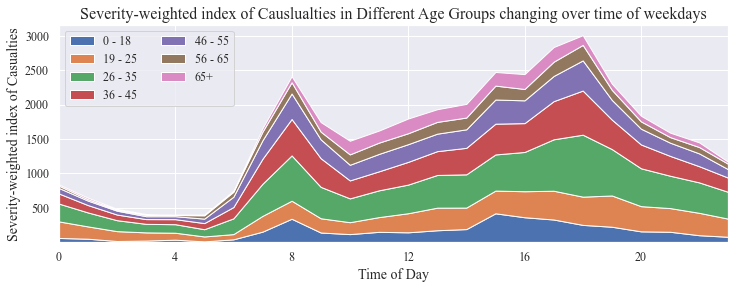

In [196]:
# get values of the SWI for different age groups in one day
swi_age = accidents_swi_age.groupby(['Hour', 'Age_Band']).sum().SWI.unstack().fillna(0)

# plot severity-weighted index of causlualties in different age groups
axes = swi_age.index
values = swi_age.T.values
age_groups = age_names

legend_font = 12
label2_font = 14
figure2_font = 12

# color = ['mistyrose','slmon','tomato','red','gold','palegreen','dodgerblue',]
fig, ax = plt.subplots(figsize=(12,4))
ax.stackplot(axes, values,
             labels=age_groups)
ax.legend(loc='upper left',prop={'size':legend_font},ncol=2)
ax.xaxis.set_major_locator(MultipleLocator(4.0))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(0,23)
ax.set_xticklabels(['0','0','4','8','12','16','20','24'],fontsize=figure2_font)
ax.set_yticklabels(['','500','1000','1500', '2000','2500','3000'],fontsize=figure2_font)

ax.set_title('Severity-weighted index of Causlualties in Different Age Groups changing over time of weekdays',fontsize=label2_font+2)
ax.set_xlabel('Time of Day',fontsize=label2_font)
ax.set_ylabel('Severity-weighted index of Casualties',fontsize=label2_font)

plt.show()

In [197]:
# find the accident distribution by age groups in weekends
swi_age_weekend = accidents_swi_age[accidents_swi_age['Day_ID']==1]

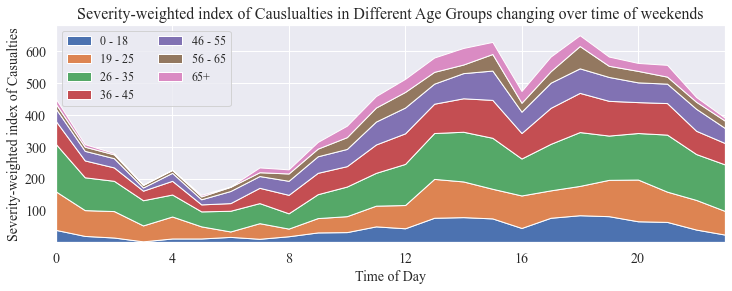

In [198]:
# get values of the SWI for different age groups in one day
swi_age = swi_age_weekend.groupby(['Hour', 'Age_Band']).sum().SWI.unstack().fillna(0)

# plot severity-weighted index of causlualties in different age groups
axes = swi_age.index
values = swi_age.T.values
age_groups = age_names

# color = ['mistyrose','slmon','tomato','red','gold','palegreen','dodgerblue',]
fig, ax = plt.subplots(figsize=(12,4))
ax.stackplot(axes, values,
             labels=age_groups)
ax.legend(loc='upper left',prop={'size':legend_font},ncol=2)
ax.xaxis.set_major_locator(MultipleLocator(4.0))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(0,23)
ax.set_xticklabels(['0','0','4','8','12','16','20','24'],fontsize=label2_font)
ax.set_yticklabels(['','100','200','300','400','500','600'],fontsize=label2_font)

ax.set_title('Severity-weighted index of Causlualties in Different Age Groups changing over time of weekends',fontsize=label2_font+2)
ax.set_xlabel('Time of Day',fontsize=label2_font)
ax.set_ylabel('Severity-weighted index of Casualties',fontsize=label2_font)

plt.show()

## 2.2 Spatial Analysis of Road Traffic Accidents

### 2.2.1 Hot Spots Detection

The planar KDE is created through QGIS, while network KDE is created through SANET

### 2.2.2 Clustering Tendency of Road Traffic Accidents

In [109]:
# define the spatial weight
def SpatialWeight(gdf,indicator=''):
    from libpysal.weights import Queen

    # Create the spatial weights matrix by Queen
    w_queen = Queen.from_dataframe(gdf)
    if w_queen.pct_nonzero == 0:
        print ('Error: %.4f'%w_queen.pct_nonzero)
    else:
        gdf.to_file(driver='ESRI Shapefile', filename='./Supplemental File/data/map/accidents_lsoa.shp')
        W_queen = ps.lib.weights.Queen.from_shapefile('./Supplemental File/data/map/accidents_lsoa.shp')
        W_queen.transform = 'r' # row-standardize the contiguity weights
        Spatial_Lag = ps.lib.weights.lag_spatial(W_queen, gdf[indicator]) #spatial lag of the HPI
    
        return w_queen, Spatial_Lag

In [105]:
# calculate Moran's I index
def MoransI(gdf, graph = '', indicator=''):
    from pysal.explore import esda
    if graph == 'scatter':
        # Moran Scatter plot
        accidents=gdf[indicator]
        _, accidents_Lag = SpatialWeight(gdf,indicator=indicator)

        b,a = np.polyfit(accidents, accidents_Lag, 1)
        f, ax = plt.subplots(1, figsize=(10, 8))
        plt.plot(accidents, accidents_Lag, '.', color='firebrick')

        # dashed vert at mean of the last year's private rent level
        plt.vlines(accidents.mean(), accidents_Lag.min(), accidents_Lag.max(), linestyle='--')
        # dashed horizontal at mean of lagged private rent
        plt.hlines(accidents_Lag.mean(), accidents.min(), accidents.max(), linestyle='--')

        # red line of best fit using global I as slope
        plt.plot(accidents, a + b*accidents, 'r')
#         plt.title('Moran Scatterplot', fontsize=14)
        plt.ylabel('Spatial Lag of accidents')
        plt.xlabel('The SWI index of road traffic accidents')
    
    elif graph == 'reference':
        # Reference Distribution
        # call moran function
        w_queen, _ = SpatialWeight(gdf,indicator=indicator)
        mi = esda.moran.Moran(gdf[indicator], w_queen) 
        # print out the moran's I value
        print("The moran's I value is {} with p-value of {} and z-score of {}".format(mi.I, mi.p_sim, mi.z_sim))

        plt.figure(figsize=(8,6)) 
        sns.kdeplot(mi.sim, shade=True)
        plt.vlines(mi.I, 0, 40, color='r')
        plt.vlines(mi.EI, 0, 40)
        plt.xlabel("Moran's I")
#         plt.title("Reference Distribution", fontsize=14)

In [106]:
# plot LISA at LSOA level
def LISA(gdf,indicator=''):
    w_queen, _ = SpatialWeight(gdf,indicator=indicator)
    
    # Local spatial autocorrelation
    lisa = ps.explore.esda.Moran_Local(gdf[indicator].values, w_queen, permutations=999)
    
    gdf['lag_rate'] = ps.lib.weights.lag_spatial(w_queen, gdf[indicator])
    sigs = gdf[indicator][lisa.p_sim <= .05]
    W_sigs = gdf['lag_rate'][lisa.p_sim <= .05]
    insigs = gdf[indicator][lisa.p_sim > .05]
    W_insigs = gdf['lag_rate'][lisa.p_sim > .05]
    
    # plot LISA cluster map
    from pysal.viz.splot.esda import lisa_cluster
    fig_lisa, ax_lisa=plt.subplots(1, figsize=(14,10))
    fig_lisa = lisa_cluster(lisa, gdf, ax=ax_lisa)
    # plt.title("LISA Cluster Map for road traffic accidents ", fontsize=14)
    plt.show()
    return lisa

In [107]:
# calculate SWI index of accidents in each LSOA
accidents_lsoa = day_hour_data.groupby('lsoa')['SWI'].count()
joint_gdf_accidents = lsoa_gdf.merge(accidents_lsoa,on='lsoa', how='outer').fillna(0)

The moran's I value is 0.24935588985426244 with p-value of 0.001 and z-score of 28.78347996076974


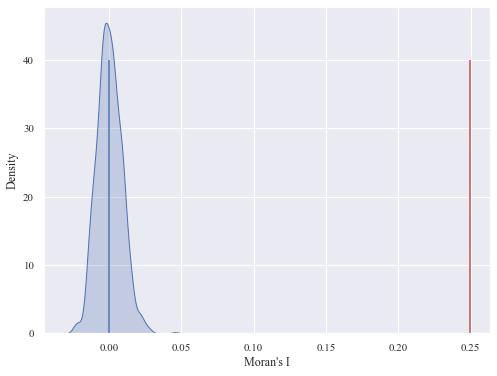

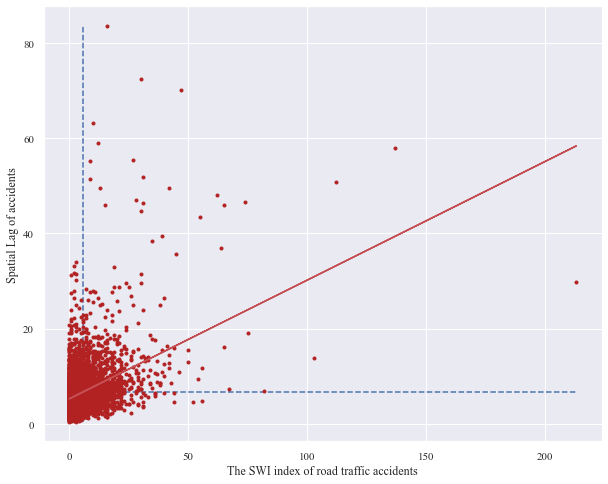

In [110]:
# plot reference distribution
MoransI(joint_gdf_accidents, graph='reference', indicator='SWI')
# plot scatter 
MoransI(joint_gdf_accidents, graph='scatter', indicator='SWI')

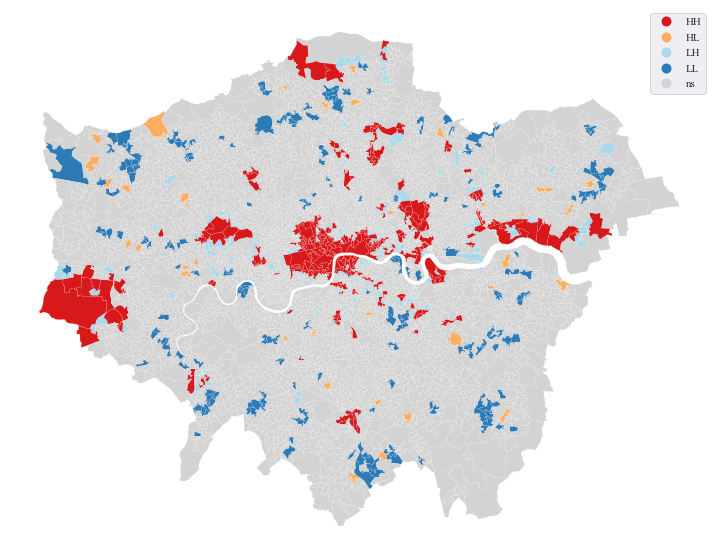

In [111]:
x = LISA(joint_gdf_accidents, indicator='SWI')

### 2.2.3 Spatial Relationship between Accidents and POI Categories

This section is explored through GeoDa

## 2.3 Factor Analysis of Road Traffic Accidents

### 2.3.1 Regression Analysis
In this section, data is processed through python, see jupyter notebook: Regression_processing.ipynb. The OLS, Poisson and negative binomial regression is run by Rstudio, see R script: Regression.R

### 2.3.2 Geographical Detector-Based Analysis

The result of GeoDatector:
Please see: Supplemental File\Factor_analysis\GeoDetector\all_accident_2019\pattern_all.xlsm

# 2.4 Spatiotemporal Pattern Mining of road traffic accidents

### 2.4.1 Tensor Construction

In [115]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker
from tensorly import backend as T

In [116]:
# add index for each LSOA
def LSOAIndex(dataframe):
    dataframe = dataframe.sort_values(by="code", ascending=True)
    
    #tensor_data['Road_ID2'] = pd.Series(np.array(len(_rearch_data.WSI)))
    dataframe['code2'] = pd.Series(np.array(len(dataframe['code'])))
    
    _lsoa_id = dataframe['code'].unique()
    # add index for each lsoa
    index_lsoa = 0
    for i in _lsoa_id:
        dataframe['code2'][dataframe['code'] == i] = index_lsoa
        index_lsoa += 1
    return dataframe

In [129]:
# prepare the dataset for tensor construction
raw_tensor_data = raw_accidents_age.copy()
# change the range of attribute 'Day' from [1,7] into [0,6]
raw_tensor_data['Day'] = raw_tensor_data['Day'] - 1

# Select data on weekdays
weekday_ts_data = raw_tensor_data[raw_tensor_data['Day_ID']==0]
weekday_ts_data = LSOAIndex(weekday_ts_data)

# Select data and weekend
weekend_ts_data = raw_tensor_data[raw_tensor_data['Day_ID']==1]
weekend_ts_data = LSOAIndex(weekend_ts_data)

In [219]:
# model accident data through a tensor
def TensorBuildLSOA(data):
    
    _rearch_data = data
    _age = _rearch_data['Age_Band'].unique()
    _age_num = len(_age)
    _lsoa = _rearch_data['code2'].unique()
    _lsoa_num = len(_lsoa)
    _hour = data['Hour'].unique()
    _hour_num = len(_hour)
    
    
    # build a empty tensor
    tensor = [[[0 for h in range(_hour_num)] for y in range(_age_num)] for y in range(_lsoa_num)]

     # fill the tensor with WSI from dataset
    for ind, row in _rearch_data.iterrows():
        #tensor[row.Date_ID][row.Road_ID2][row.Hour] = row.WSI
        tensor[row['code2']][int(row['Age_Band'])][row['Hour']] = row['SWI']
        
        tensor = tl.tensor(tensor,dtype = tl.float32)
    return tensor

### 2.4.2 Parameter Selection and Model Evaluation

In [136]:
# define the size of ranks
def RankList(x, age_num=0, hour_num=0):
    rank_num = [x, age_num, hour_num]
    rank_list = []
    for i in range(rank_num[0]):
        rank_k = [i+1,age_num,hour_num]
        rank_list.append(rank_k)
    return rank_list

In [185]:
# select a approariate size of rank through KL divergency
def NNTKL(tensor, spatial_num=0, hour_num=0, age_num=0):
    import scipy
    
    # define a set of rank list
    rank_list = RankList(spatial_num, hour_num=hour_num, age_num = age_num) # considering 4 age groups and the threshold (n = 3) of the number of the hourly pattern groups: normal,daylight and evening
    # define a set of KL list
    KL_list = []

    for i in rank_list:
        # get core tensor and factors by non negative tucker tensor decomposition
        core, factors = non_negative_tucker(tensor, rank = i,n_iter_max = 1000, init = 'svd')
        # reconstruct the tensor
        pred_tensor = tl.tucker_to_tensor((core, factors))
        # calculate KL value of each rank
        KL = scipy.stats.entropy(tensor.flatten(), pred_tensor.flatten())
        KL_list.append(KL)

    # define a dataframe of KL values and ranks
    fig1=plt.figure()
    KL_pd = pd.Series(KL_list,name='KL')
    KL_result_pd = pd.DataFrame(rank_list, columns = ['spatial_num','age_num','hour_num'])
    KL_result_pd['KL'] = KL_pd
    # plot KL values with different ranks
    from matplotlib.ticker import MaxNLocator
    plt.plot(KL_list)
    index_ls =[i+1 for i in range(spatial_num)]
    plt.xticks(range(spatial_num),index_ls)
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('The number of spatial patterns')
    plt.ylabel('The value of KL divergence')

In [154]:
from matplotlib import ticker

### 2.4.3 Tensor Decomposition

In [220]:
# build a tensor of accidents on the weekdays
tensor_wd = TensorBuildLSOA(weekday_ts_data)

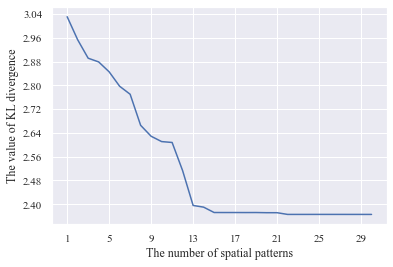

In [221]:
# rank size selection and model evaluation
NNTKL(tensor_wd, spatial_num=30, hour_num=3, age_num=5)

In [225]:
# obtain the most approariate rank of [13,5,3]
core_weekday, factors_weekday = non_negative_tucker(tensor_wd, rank = [13,5,3],n_iter_max = 1000, init = 'svd')

In [245]:
# build a tensor of accidents on the weekends
tensor_we = TensorBuildLSOA(weekend_ts_data)

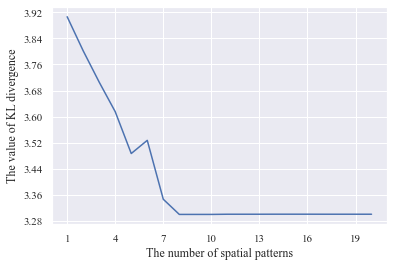

In [227]:
NNTKL(tensor_we, spatial_num=20, hour_num=2, age_num=4)

In [250]:
# obtain the most approariate rank of [8,4,2]
core_weekend, factors_weekend = non_negative_tucker(tensor_we , rank = [8, 4, 2],n_iter_max = 1000, init = 'svd')

### 2.4.4 Pattern analysis of road traffic accidents during weekdays

In [348]:
# plot temporal patterns
def PlotTemporalPattern(pattern):
    n = pattern.shape[1]
    pattern_list = ['pattern_{0}'.format(i+1) for i in range(n) ]
    pattern_df = pd.DataFrame(pattern, columns = pattern_list)
    lengend_ls = []
    for i in range(len(pattern_list)):
        pattern_df[pattern_list[i] ].plot(legend=True)
        index_ls =[i+1 for i in range(24)]
        plt.xticks(range(24),index_ls)
        plt.xlabel('Time of day')
        plt.ylabel('The degree of accidents')
        # set the lengend for each pattern
        lengend = 'Temporal pattern {}'.format(i+1)
        lengend_ls.append(lengend)
    plt.legend(lengend_ls)
    plt.show()

In [195]:
# joint dataframe to geodataframe
def joint_df_gdf(dataframe, patterns):
    names_ls = []
    for i in range(len(patterns[0])):
        names = ['Topic {}'.format(i+1)]
        names_ls.extend(names)
    spatial_pd = pd.DataFrame(patterns, columns = names_ls)
    spatial_pd.reset_index(inplace = True)
    spatial_pd.rename(columns={'index':'code2'}, inplace = True)
    
    lsoa_code = pd.DataFrame(dataframe['code'].unique(), columns = ['code'])
    lsoa_code.reset_index(inplace = True)
    lsoa_code.rename(columns={'index':'code2'}, inplace = True)
    
    lsoa_ntd_pd = pd.merge(lsoa_code,spatial_pd, on = 'code2')
    lsoa_gdf = gpd.read_file('./data/London/regression/All/nbregression_data_lsoa.shp')
    #     lsoa_gdf = gpd.read_file('./data/Map/LSOA/lsoa_accidents.shp')
    lsoa_ntd_gdf = lsoa_gdf.merge(lsoa_ntd_pd, on='code', how = 'left')
    lsoa_ntd_gdf = lsoa_ntd_gdf.fillna(0)
    return lsoa_ntd_gdf

In [335]:
# plot spatial 
def PlotSpatialPattern(dataframe, patterns, topic=0, name=''):   
    
    # Set up figure and axis
    f, ax = plt.subplots(figsize=(12,10))
    patterns_ls = []
    for i in range(len(patterns)):
        pattern = (patterns[i]-patterns[i].min())/(patterns[i].max()-patterns[i].min())
        patterns_ls.append(pattern)
    patterns = np.array(patterns_ls)
    
    lsoa_ntd_gdf = joint_df_gdf(dataframe, patterns)
    
    # set colorbar for maps
    vmin = patterns.min()
    vmax = patterns.max()
    # Plot Number of Airbnbs
    # Quickly plot 
    lsoa_ntd_gdf.plot(column='Topic {}'.format(topic+1), cmap = 'OrRd', legend=True, ax=ax, 
                      vmin = vmin, vmax = vmax)
    # Remove axis frame
    ax.set_axis_off()
    # Change background color of the figure
    f.set_facecolor('1')
    # set up the title
    #f.suptitle('The accident rate of topic {} in London'.format(topic+1), size=25)
    f.savefig('./Supplemental File/graphs/topic_{}_{}.png'.format(topic+1,name))

    plt.show()
    return lsoa_ntd_gdf

In [278]:
# plot core pattern
def CoreAnalysis(core,name='',shape=''):
    plt.clf()
    n = 0
    
    # reshape the tensor into age, spatial, temporal sizes of 5,13,3
    core = tl.unfold(tl.tensor(core),mode=1)
    core = tl.fold(core,mode=0,shape=(shape[0],shape[1],shape[2]))

    for i in range(len(core)):
        n += 1
        f = plt.figure(dpi=80)
        age = pd.DataFrame(core[i]).apply(lambda x: round(x / sum(x),3))
        
        daily_pattern = [i+1 for i in range(len(core[0][0]))]
        spatial_pattern = [i+1 for i in range(len(core[0]))]
        
        sns.heatmap(data=age,cmap=sns.dark_palette("purple", as_cmap=True),xticklabels=daily_pattern,yticklabels=spatial_pattern)
        plt.xlabel('Daily patterns', fontsize=12,color='k')    
        plt.ylabel('Spatial patterns', fontsize=12,color='k')
        plt.title('Core tensor analysis of road traffic accidents')
        # save to file
        f.savefig('./Supplemental File/graphs/core_{}_{}.png'.format(i+1,name))

In [223]:
# obtain patterns
spatial_wd = factors_weekday[0]
age_wd = factors_weekday[1]
hourly_wd = factors_weekday[2]

##### (1) Daily pattern analysis

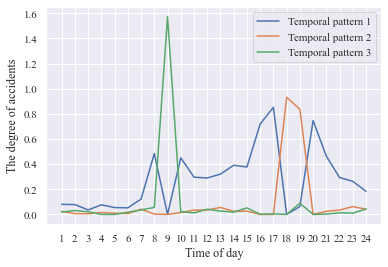

In [349]:
PlotTemporalPattern(hourly_wd)

#### （2）Age pattern analysis

In [232]:
# calculate the proportion of age groups
age_pattern= pd.DataFrame(age_wd).apply(lambda x: round(x / sum(x),3))

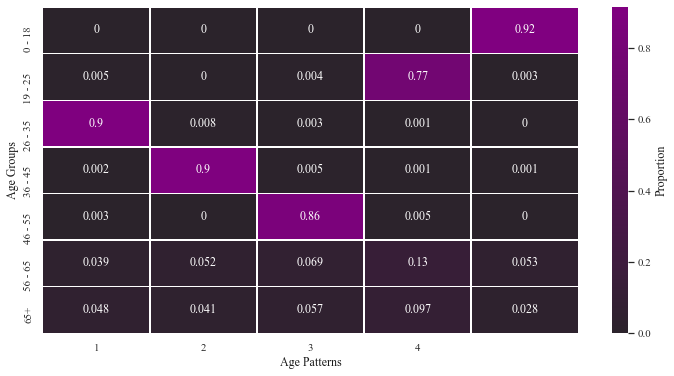

In [238]:
# draw a heatmap with the WSI index of accidents
days = [i+1 for i in range(7)]
age = [i+1 for i in range(4)]

f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(age_pattern, annot=True, linewidths=.5, ax=ax,cmap=sns.dark_palette("purple", as_cmap=True),xticklabels=age,yticklabels=age_names)
plt.xlabel('Age Patterns',fontsize=12, color='k')
plt.ylabel('Age Groups',fontsize=12, color='k')
cbar = ax.collections[0].colorbar
cbar.set_label(r'Proportion',fontdict=font)

#### （3）Spatial pattern analysis

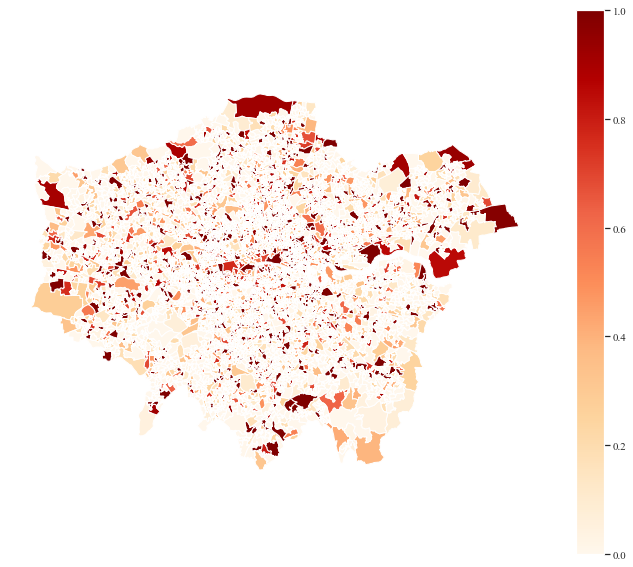

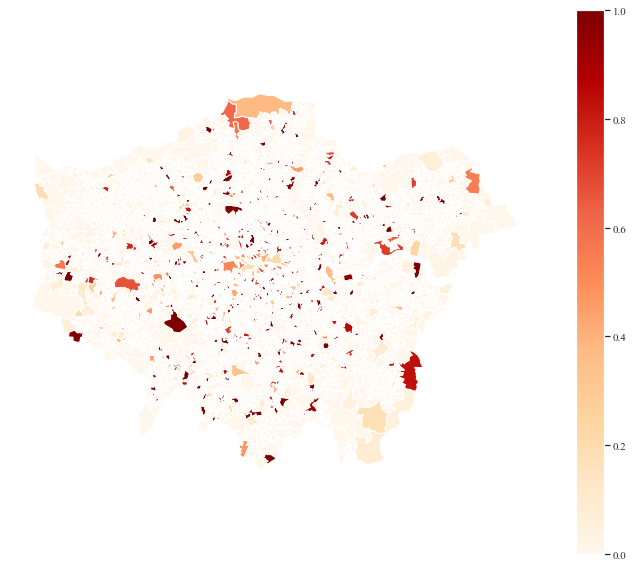

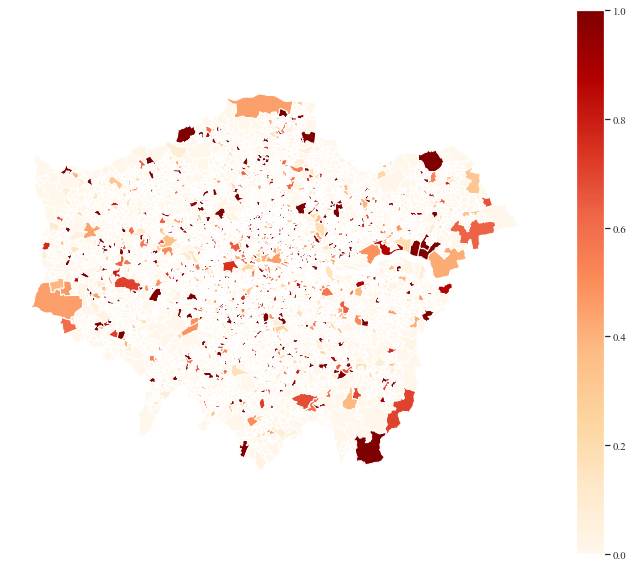

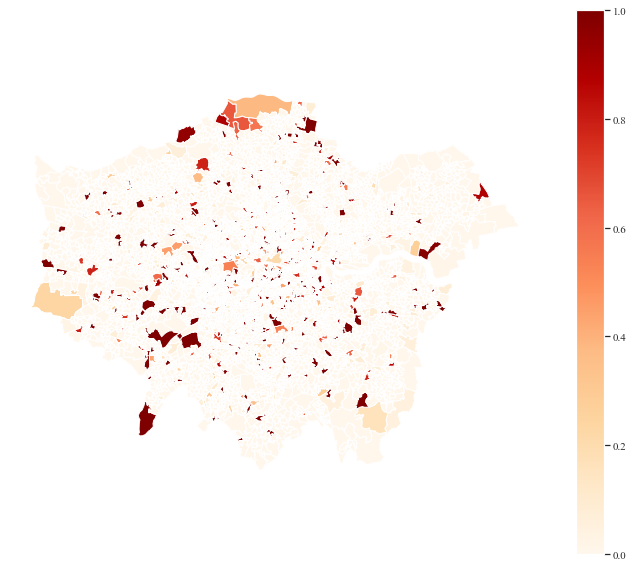

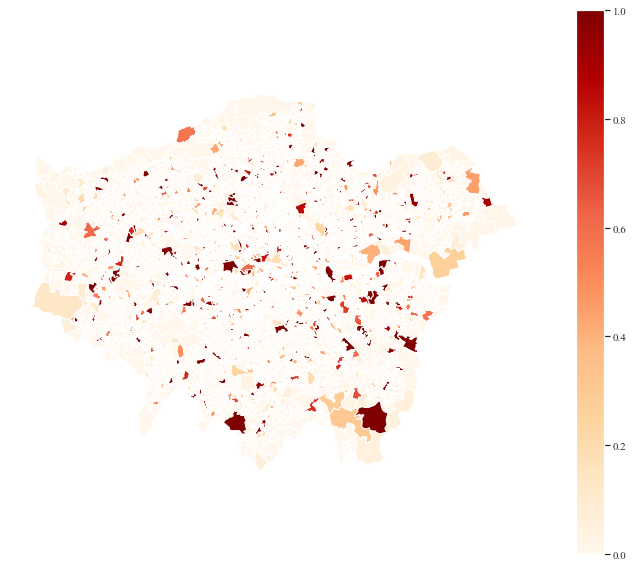

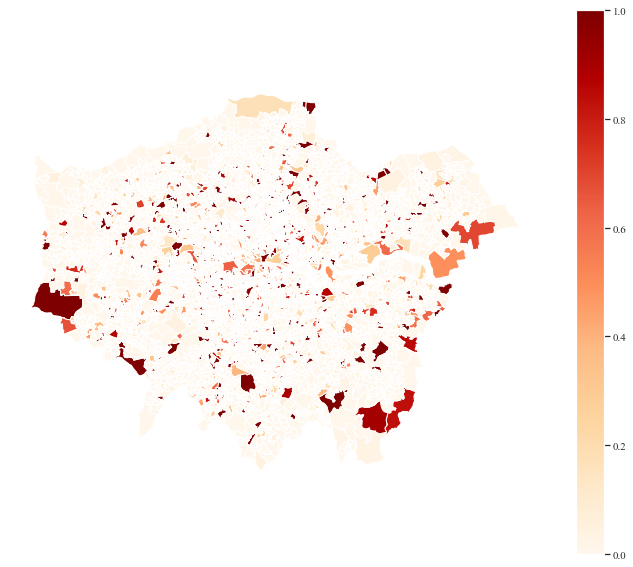

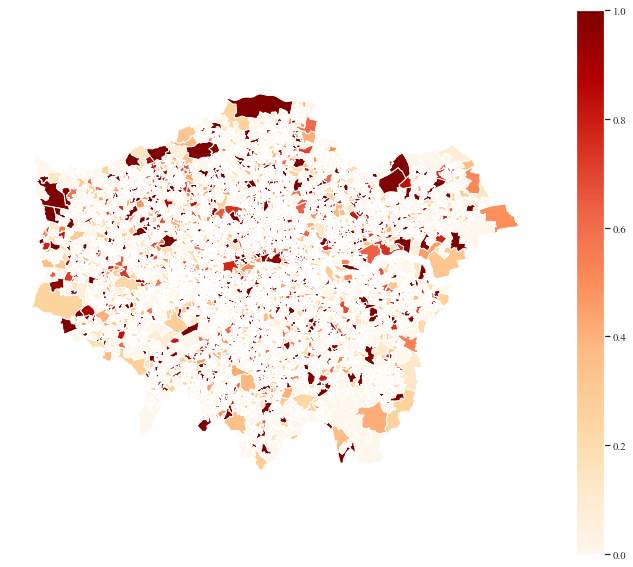

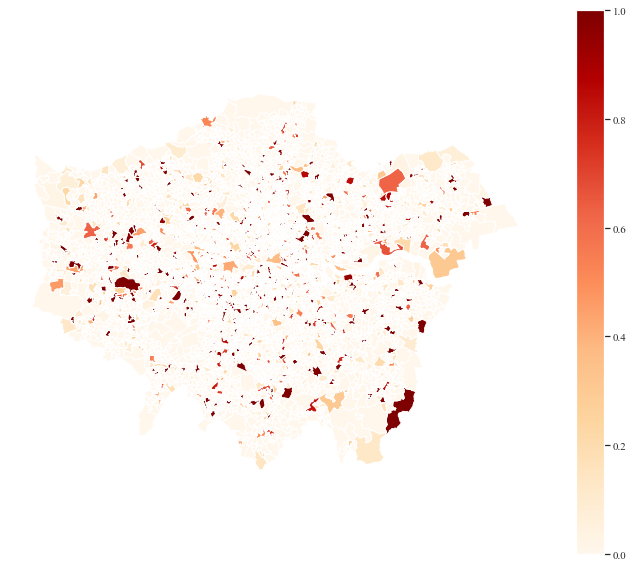

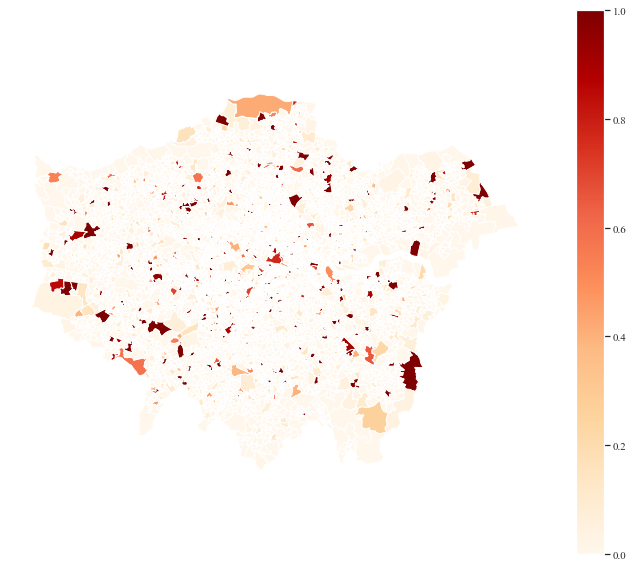

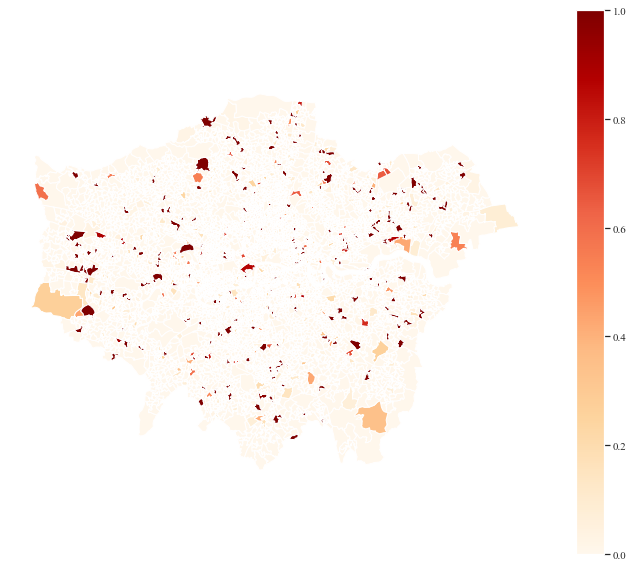

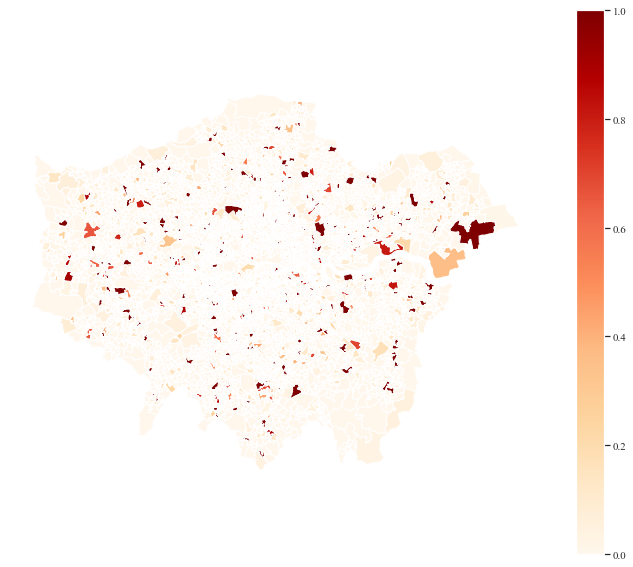

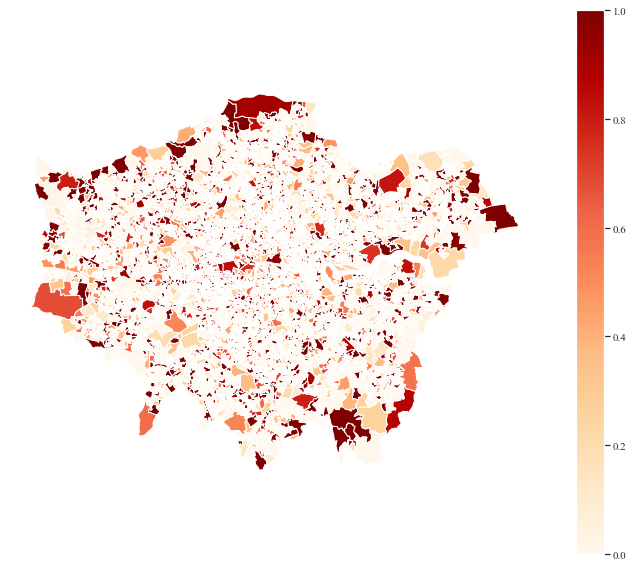

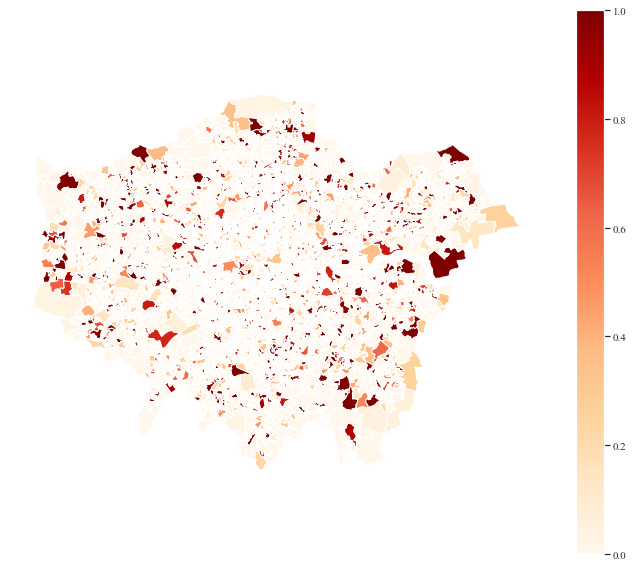

In [338]:
for i in range(len(spatial_wd[0])):
    spatial_topic_wd = PlotSpatialPattern(weekday_ts_data, spatial_wd, topic=i,name='weekdays')

In [260]:
# find risk region
def ThirdRiskyRegion(pattern, topic_num=0):
    region_topic_pd = pd.DataFrame(np.zeros([0,4]),columns = ['code','lsoa','borough','geometry'])
    for topic in range(topic_num):
        series = pattern.copy()
        region_pd = pd.DataFrame(np.zeros([0,4]),columns = ['code','lsoa','borough','geometry'])
        for i in range(3): 
            region = series[series['Topic {}'.format(topic+1)]==series['Topic {}'.format(topic+1)].max()]
            region = region.loc[:,['code','lsoa','borough','geometry']]
            series.drop(labels = region.index, axis = 0, inplace = True)
            region_pd = pd.concat([region_pd,region])
     
        region_topic_pd = pd.concat([region_topic_pd, region_pd])
        region_topic_pd['risk']=1
        region_topic_gpd = gpd.GeoDataFrame(region_topic_pd)
    return region_topic_gpd

In [261]:
regions_wd = ThirdRiskyRegion(spatial_topic_wd, topic_num=8)

##### (4)	Core tensor analysis

[[1.6845629e+00 2.0124018e-03 5.9144234e-04]
 [3.1467117e-02 6.7869411e-03 2.0821607e-03]
 [5.1793641e-01 2.1418652e-02 9.2649665e-03]
 [2.9450029e-04 4.0599442e-01 4.5370968e+01]
 [1.1854899e+00 1.3862221e-02 7.3349192e-03]
 [4.9051011e-01 6.5577034e+01 3.5580886e-08]
 [4.0281361e+01 1.4989047e-06 6.9681233e-01]
 [4.1544512e-01 1.9418228e-04 7.2870273e-05]
 [1.9950679e-01 3.0056020e-04 2.1530713e-03]
 [4.7677443e-03 4.0784295e-04 2.1176324e-04]
 [2.8278717e-01 6.8085827e-04 1.3982816e-05]
 [9.6015580e-02 7.8105298e-04 4.4923980e-04]
 [4.2761821e-01 2.0002779e-03 2.2945318e-05]]


<Figure size 432x288 with 0 Axes>

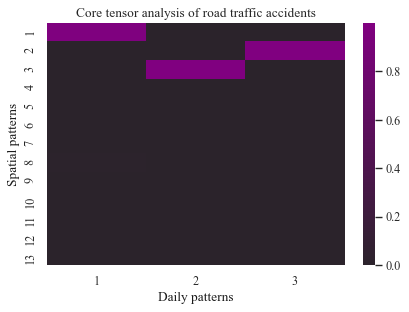

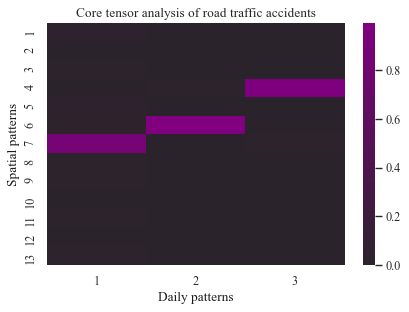

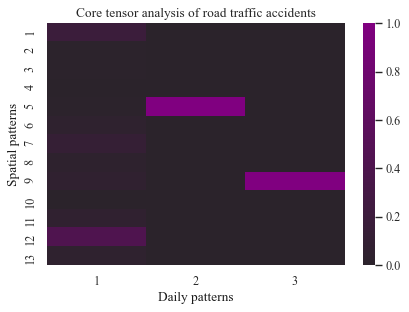

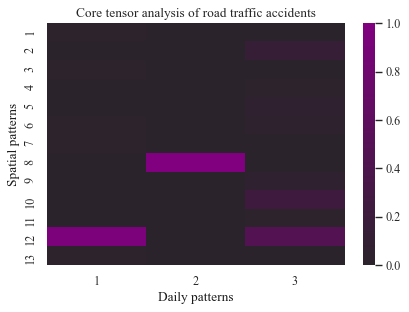

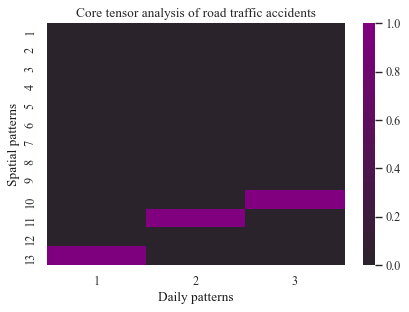

In [277]:
CoreAnalysis(core_weekday, name='weekdays',shape=(5,13,3))

### 2.4.5 Pattern analysis of road traffic accidents during weekends

In [252]:
# find patterns
spatial_we = factors_weekend[0]
age_we = factors_weekend[1]
hourly_we = factors_weekend[2]

In [253]:
#### （1）Daily pattern analysis

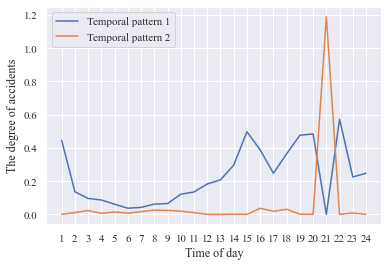

In [350]:
PlotTemporalPattern(hourly_we)

#### （2）Age pattern analysis

In [255]:
age_pattern= pd.DataFrame(age_we).apply(lambda x: round(x / sum(x),3))

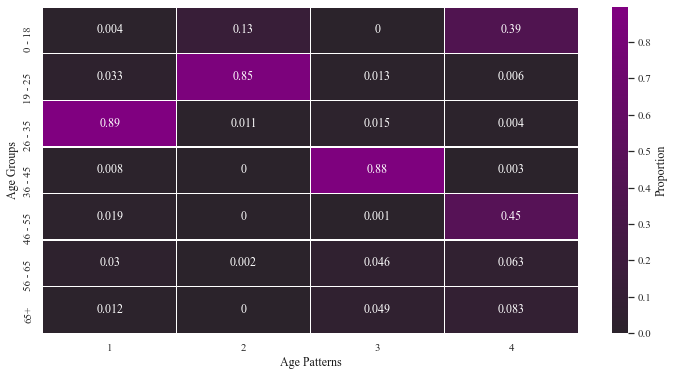

In [256]:
# draw a heatmap with the WSI index of accidents
days = [i+1 for i in range(7)]
age = [i+1 for i in range(4)]

f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(age_pattern, annot=True, linewidths=.5, ax=ax,cmap=sns.dark_palette("purple", as_cmap=True),xticklabels=age,yticklabels=age_names)
plt.xlabel('Age Patterns',fontsize=12, color='k')
plt.ylabel('Age Groups',fontsize=12, color='k')
cbar = ax.collections[0].colorbar
cbar.set_label(r'Proportion',fontdict=font)

#### （3）Spatial pattern analysis

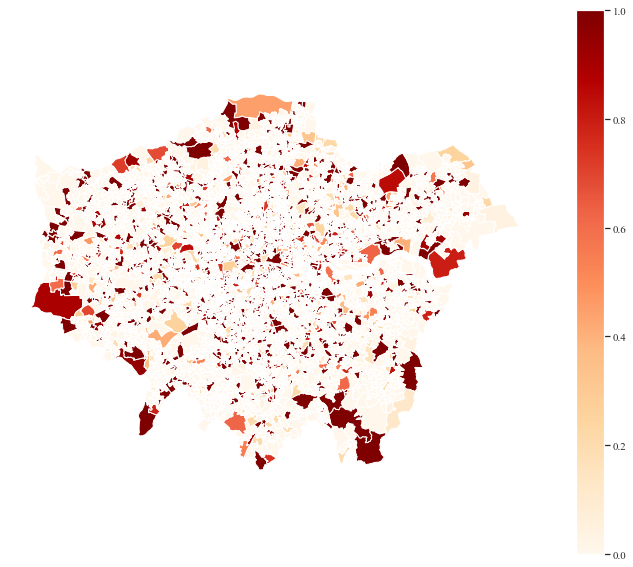

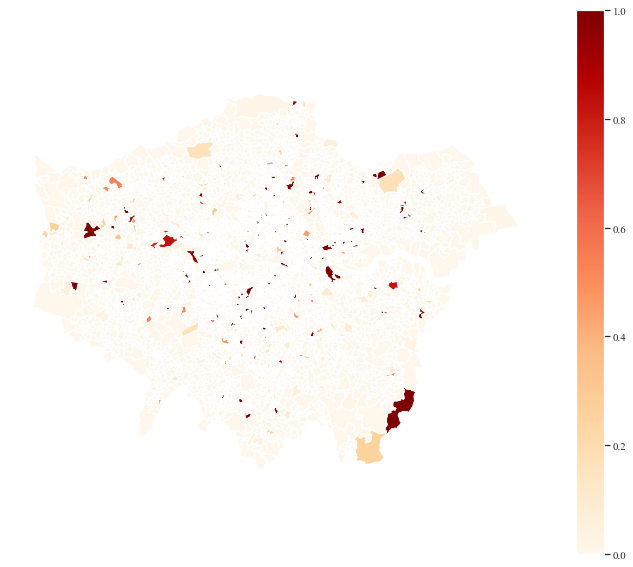

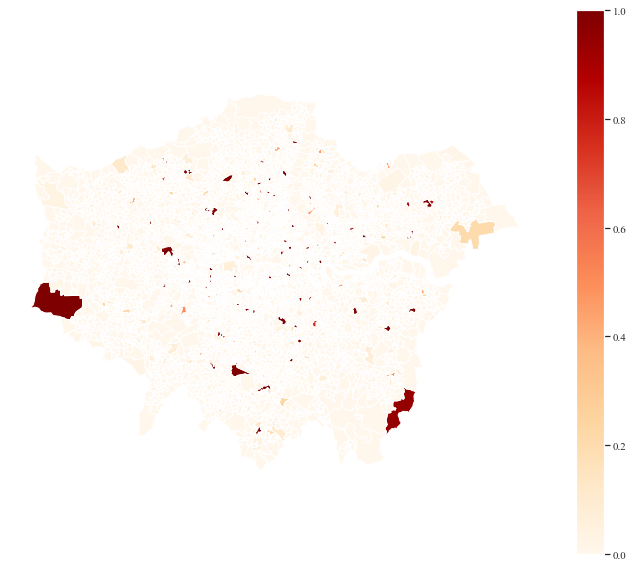

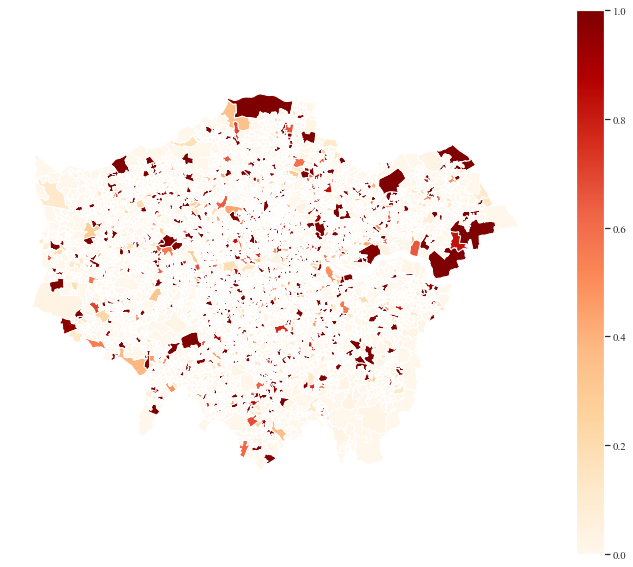

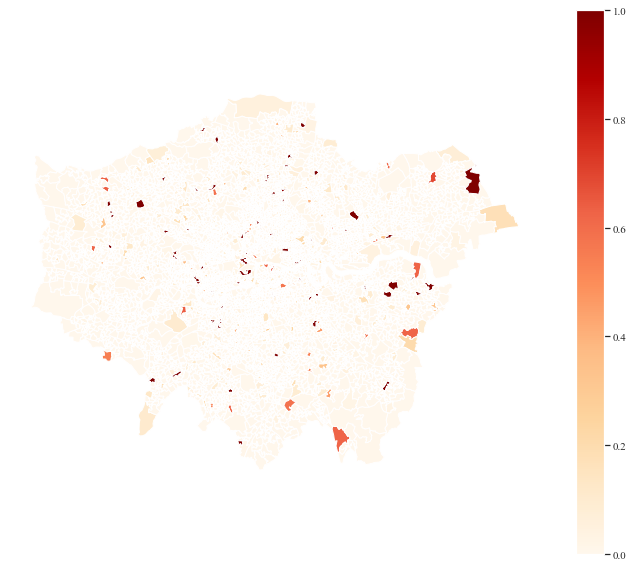

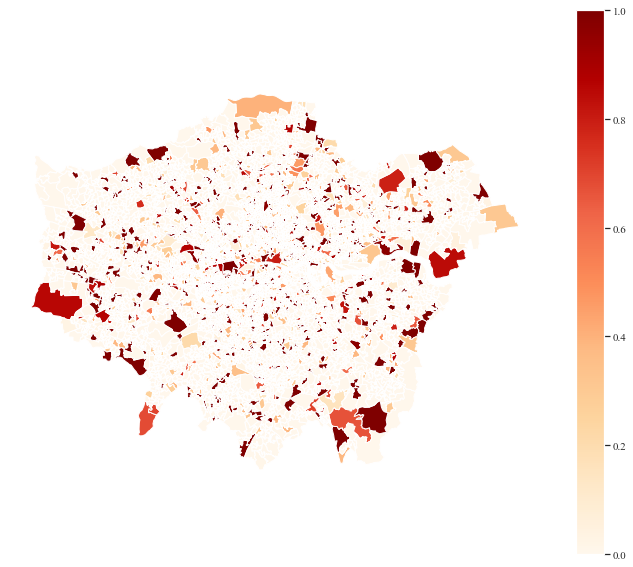

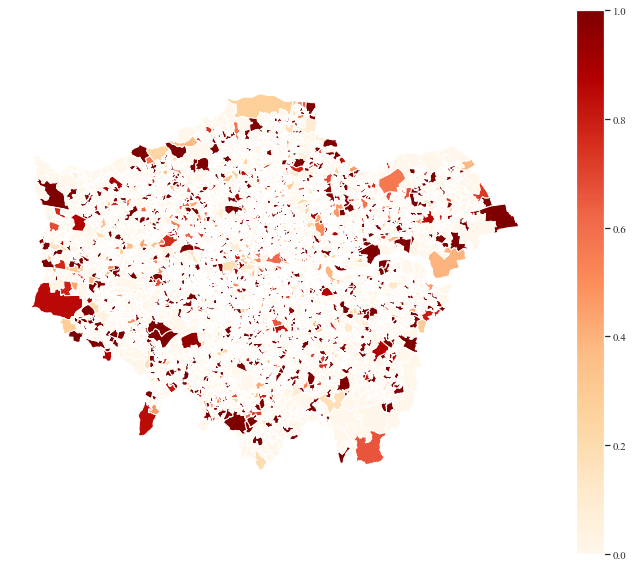

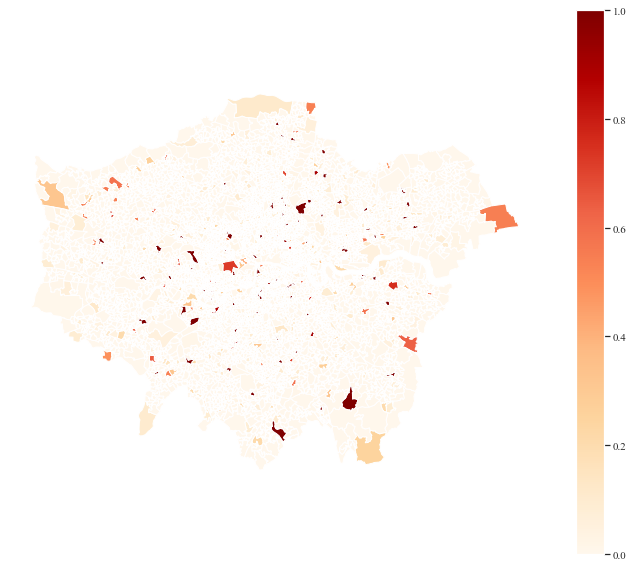

In [339]:
for i in range(len(spatial_we[0])):
    spatial_topic_we = PlotSpatialPattern(weekend_ts_data, spatial_we, topic=i,name='weekends')

In [262]:
we_regions = ThirdRiskyRegion(spatial_topic_we, topic_num=8)

##### (4)	Core tensor analysis

[[4.7982204e-01 1.1783412e-02]
 [2.4401633e-01 8.0574431e-02]
 [8.2856879e-02 2.3924088e+01]
 [2.0855955e+01 4.9294769e-03]
 [5.1566884e-02 3.9766380e-04]
 [1.5664004e-01 1.1476765e-02]
 [2.4634390e-01 7.3189847e-04]
 [2.7790507e-02 1.9613499e-02]]


<Figure size 432x288 with 0 Axes>

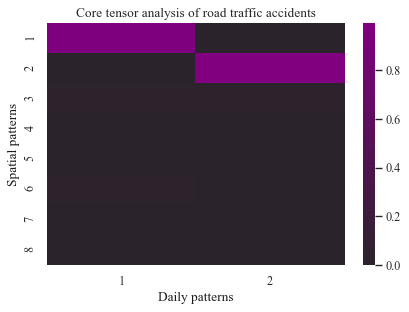

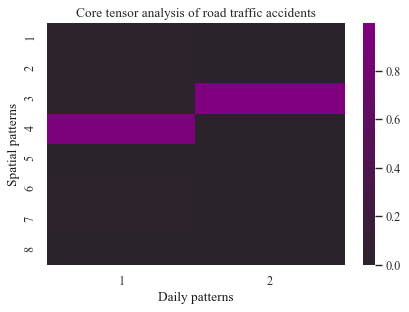

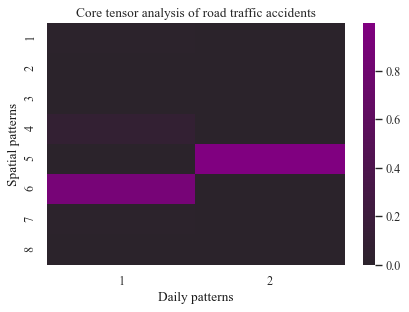

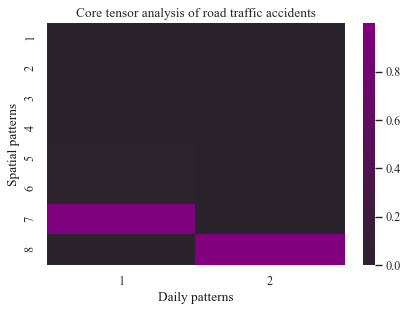

In [287]:
CoreAnalysis(core_weekend, name='weekends',shape=(4,8,2))

### 2.4.6 Spatiotemporal pattern analysis for each age group

Please see: \Supplemental File\Factor_analysis\GeoDetector\accident_for_each_age_group\tensor_weekdays